<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/RecercaExtra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import torch
import cv2
import csv
import random
import numpy as np
import ast
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json
import sys
import ast
import shutil

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'
DOWNLOAD = False
PUT = False
RUN = 22

TESTING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/testing_features.txt'
TRAINING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/training_features.txt'
HAIRIMG = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/HairFeature/'


TESTING_NOHAIRY = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/19/Features/testing_features.txt'
TRAINING_NOHAIRY =  '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/19/Features/training_features.txt'

if PUT:
  if os.path.exists(HAIRIMG):
      shutil.rmtree(HAIRIMG)

  os.makedirs(HAIRIMG,exist_ok=True)

drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/


# IMAGE_PATHS1 = glob('/content/sample_data/HAM10000_images_part_1/*.jpg')
# IMAGE_PATHS2 = glob('/content/sample_data/HAM10000_images_part_2/*.jpg')
# IMAGE_PATHS3 = glob('/content/sample_data/ham10000_images_part_1/*.jpg')
# IMAGE_PATHS4 = glob('/content/sample_data/ham10000_images_part_2/*.jpg')
# IMAGE_PATHS = IMAGE_PATHS1 + IMAGE_PATHS2 + IMAGE_PATHS3 + IMAGE_PATHS4
# PATH_TRAINING_DISTANCES = "/content/drive/MyDrive/Features/Embeddings/embeddings_pesos_resnet152multiclass_3.pt.txt" #embeddings training
# DISTANCES_IMAGES = "/content/drive/MyDrive/Features/Dist/1/distances.txt" #distàncies de totes les imatges de test

IMG_PATH = '/content/sample_data/HAM10000_images_part_1/'

#28921 28777 26292 25746 25216 24803 24411 26879 26286 25746 25526 25466

IMATGES_INTERES = ["ISIC_0027790.jpg","ISIC_0027010.jpg","ISIC_0025415.jpg","ISIC_0025606.jpg","ISIC_0028732.jpg"
,"ISIC_0026193.jpg","ISIC_0026947.jpg"
,"ISIC_0027970.jpg","ISIC_0024891.jpg","ISIC_0026315.jpg","ISIC_0026392.jpg","ISIC_0027199.jpg","ISIC_0026127.jpg"
,"ISIC_0026303.jpg","ISIC_0029097.jpg","ISIC_0025282.jpg","ISIC_0028642.jpg","ISIC_0027295.jpg","ISIC_0028424.jpg"
,"ISIC_0026184.jpg","ISIC_0024779.jpg","ISIC_0026998.jpg","ISIC_0024342.jpg","ISIC_0026615.jpg","ISIC_0026651.jpg"] #imatges amb els patrons que cercam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if PUT:
  for i in IMATGES_INTERES:
    shutil.copy(IMG_PATH+i,HAIRIMG)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
def guarda_features_hairy():
    features = []
    for j in IMATGES_INTERES:
        with open(TESTING_FEATURES_FILE, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == j:
                    features.append(ast.literal_eval(row['FC Input']))

        with open(TRAINING_FEATURES_FILE, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == j:
                    features.append(ast.literal_eval(row['FC Input']))

    with open(HAIRIMG+'saved_features.txt', 'w') as out_file:
        out_file.write(str(features))


def guarda_features_dif():
  features = []
  for j in IMATGES_INTERES:
        with open(TESTING_NOHAIRY, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == j:
                    features.append(ast.literal_eval(row['FC Input']))

        with open(TRAINING_NOHAIRY, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == j:
                    features.append(ast.literal_eval(row['FC Input']))

  with open(HAIRIMG+'noHairy_features.txt', 'w') as out_file:
      out_file.write(str(features))

# guarda_features_hairy()
# guarda_features_dif()

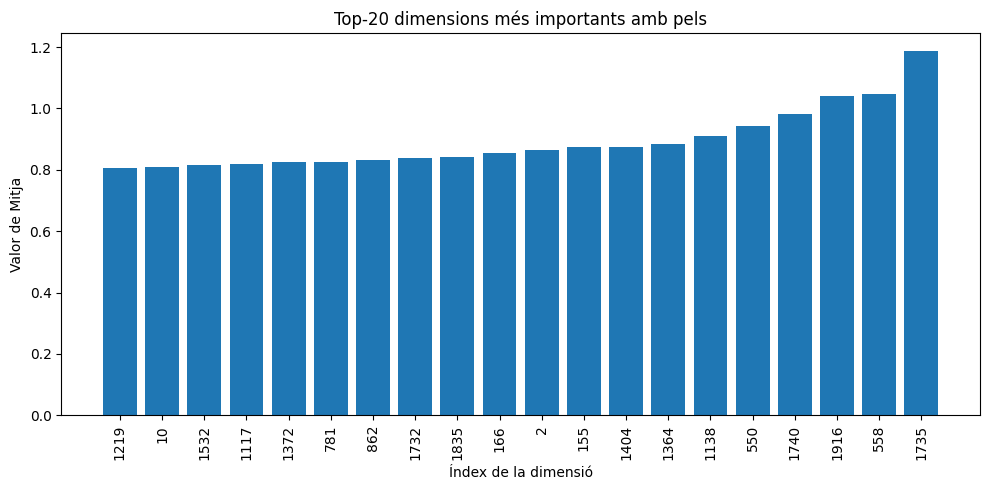

In [74]:
with open(HAIRIMG+'saved_features.txt','r') as ft:
  hairy = ast.literal_eval(ft.read())

  importance_scores = np.mean(np.abs(hairy), axis=0)


top_k = 20
top_indices1 = np.argsort(importance_scores)[-top_k:]

plt.figure(figsize=(10, 5))
plt.bar(range(top_k), importance_scores[top_indices1])
plt.xticks(range(top_k), top_indices1, rotation=90)
plt.title(f"Top-{top_k} dimensions més importants amb pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Valor de Mitja")
plt.tight_layout()
plt.show()

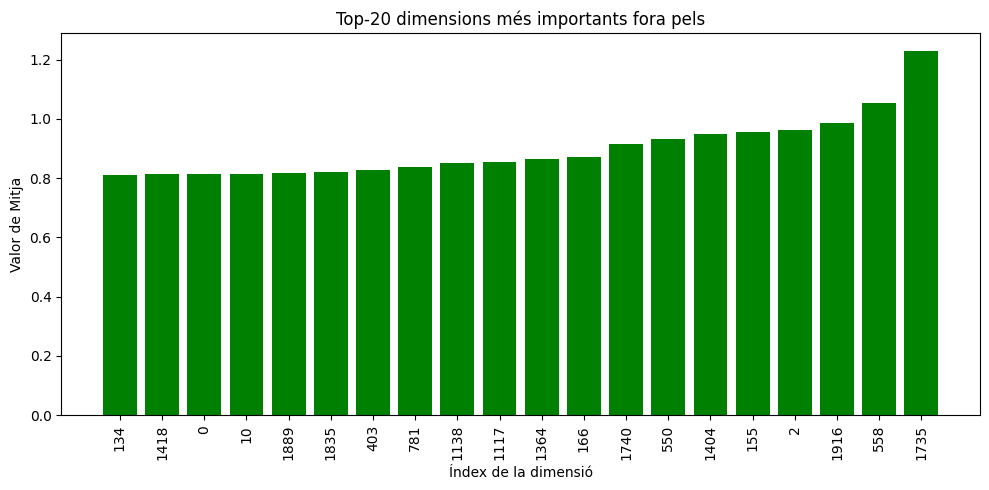

In [75]:
with open(HAIRIMG+'noHairy_features.txt','r') as ft:
  nohairy = ast.literal_eval(ft.read())

  importance_scores = np.mean(np.abs(nohairy), axis=0)


top_k = 20
top_indices2 = np.argsort(importance_scores)[-top_k:]

plt.figure(figsize=(10, 5))
plt.bar(range(top_k), importance_scores[top_indices2],color='green')
plt.xticks(range(top_k), top_indices2, rotation=90)
plt.title(f"Top-{top_k} dimensions més importants fora pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Valor de Mitja")
plt.tight_layout()
plt.show()

In [76]:
indexs_importants = []
for i in top_indices1:
  if i not in top_indices2:
    indexs_importants.append(i)
print(indexs_importants)

[np.int64(1219), np.int64(1532), np.int64(1372), np.int64(862), np.int64(1732)]


Pertanyents a l'histograma de pels i no al segon: \\
· 1219 \\
· 1532 \\
· 862 \\
· 1732 \\
· 1372

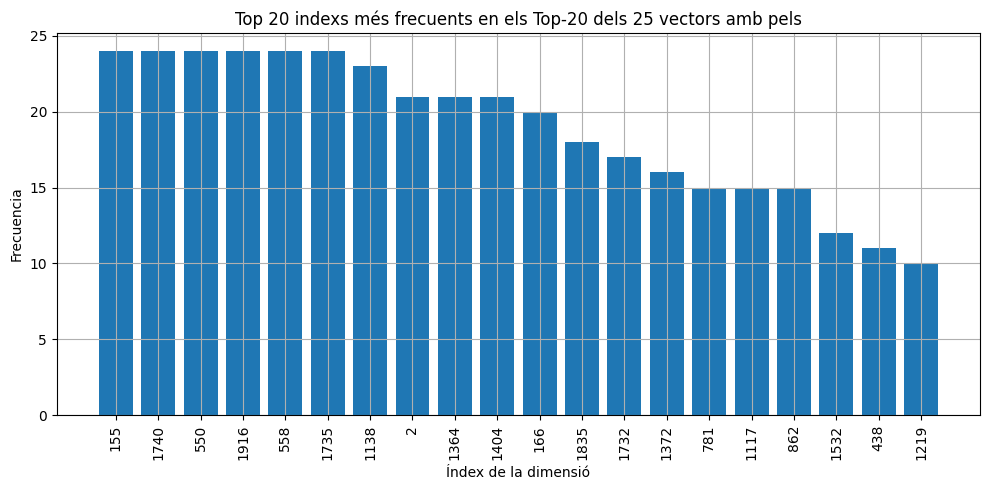

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

index_counter = defaultdict(int)
top_k = 20

# Contar frecuencia de aparición en el top-k
for vec in hairy:
    top_indices = np.argsort(vec)[-top_k:]
    for idx in top_indices:
        index_counter[idx] += 1

# Ordenar por frecuencia descendente y obtener los 20 más frecuentes
top_20_freq = sorted(index_counter.items(), key=lambda x: x[1], reverse=True)[:20]
top_indices, top_counts = zip(*top_20_freq)

# Mostrar histograma solo con los 20 más frecuentes
plt.figure(figsize=(10, 5))
plt.bar(range(20), top_counts)
plt.xticks(range(20), top_indices, rotation=90)
plt.title("Top 20 indexs més frecuents en els Top-20 dels "+str(len(IMATGES_INTERES))+" vectors amb pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.grid(True)
plt.show()

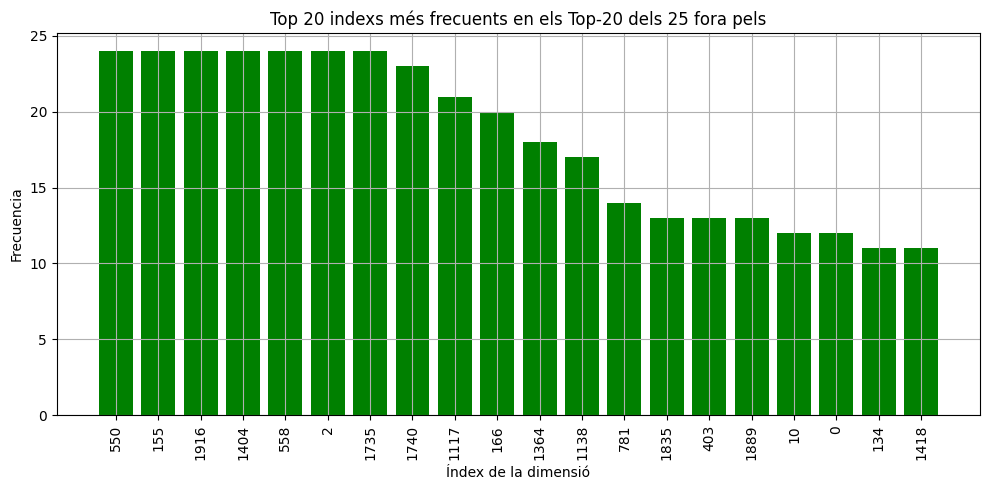

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

index_counter = defaultdict(int)
top_k = 20

# Contar frecuencia de aparición en el top-k
for vec in nohairy:
    top_indices = np.argsort(vec)[-top_k:]
    for idx in top_indices:
        index_counter[idx] += 1

# Ordenar por frecuencia descendente y obtener los 20 más frecuentes
top_20_freq = sorted(index_counter.items(), key=lambda x: x[1], reverse=True)[:20]
top_indices, top_counts = zip(*top_20_freq)

# Mostrar histograma solo con los 20 más frecuentes
plt.figure(figsize=(10, 5))
plt.bar(range(20), top_counts,color='green')
plt.xticks(range(20), top_indices, rotation=90)
plt.title("Top 20 indexs més frecuents en els Top-20 dels "+str(len(IMATGES_INTERES))+" fora pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.grid(True)
plt.show()

In [79]:
# Supón que IMAGE_PATHS ya contiene todas tus rutas
# for path in IMAGE_PATHS:  # Puedes cambiar el número de imágenes que deseas ver
#     img = Image.open(path)
#     clear_output(wait=True)  # Limpia la celda para mostrar la siguiente imagen
#     display(img)
#     print(path)
#     time.sleep(5)  # Espera 2 segundos


In [80]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [81]:
# print(vector_features)